# Logistic Regression with a Neural Network

## Packages ##

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
%matplotlib inline

In [29]:
def load_dataset():
    train_dataset = h5py.File('train_dataset.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_dataset"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["labels"][:]) # your train set labels

    test_dataset = h5py.File('test_dataset.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_dataset"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["labels"][:]) # your test set labels

    classes = ['Not Face','Face'] # np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0])) # We reshape labels to (1, m) so they align with the prediction matrix (1, m) during forward propagation and loss computation, ensuring correct matrix operations and avoiding broadcasting errors.
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [30]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

In [31]:
train_set_x_orig.shape, train_set_y.shape, test_set_x_orig.shape, test_set_y.shape

((1800, 128, 128, 3), (1, 1800), (770, 128, 128, 3), (1, 770))

y = [1], it's a 'Face' picture.


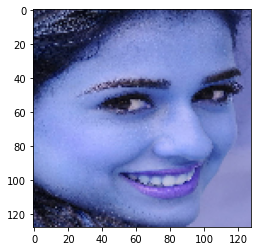

In [32]:
# Example of a picture
index = 454
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + 
       ", it's a '" + str(classes[int(np.squeeze(train_set_y[:, index]))]) +  "' picture.")


In [33]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 1800
Number of testing examples: m_test = 770
Height/Width of each image: num_px = 128
Each image is of size: (128, 128, 3)
train_set_x shape: (1800, 128, 128, 3)
train_set_y shape: (1, 1800)
test_set_x shape: (770, 128, 128, 3)
test_set_y shape: (1, 770)


Neural network formulas expect:

- X shape = (features, examples)

Fully connected neural networks cannot process images directly.
- 1D feature vectors → matrix input
Flattening bridges:
- Image data → Neural network math


In [34]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (49152, 1800)
train_set_y shape: (1, 1800)
test_set_x_flatten shape: (49152, 770)
test_set_y shape: (1, 770)
sanity check after reshaping: [48 46 75 29 26]


In [35]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

## Building the parts of algorithm ## 

### Helper functions

### Mathematically:

- 𝜎(𝑧)=1/(1+𝑒^−𝑧)	

Input: any real number (z ∈ ℝ)

Output: a value between 0 and 1

### In a neuron:

𝑧=𝑊⋅𝑋+𝑏

Where:

- W = weights

- X = input features

- b = bias

z is the linear combination before activation.

| z value      | sigmoid(z) | Meaning         |
| ------------ | ---------- | --------------- |
| Very large + | ≈ 1        | Strong positive |
| 0            | 0.5        | Uncertain       |
| Very large − | ≈ 0        | Strong negative |


In [36]:
def sigmoid(z):
    s = 1 /(1 + np.exp(-z))
    return s

In [37]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


### Initializing parameters

Logistic regression / single neuron

No symmetry problem

All weights will update differently during training

### Deep neural networks

Zero initialization would cause neurons to learn the same thing

In [38]:
def initialize_with_zeros(dim):

    w = np.zeros(shape=(dim, 1), dtype=np.float32)
    b = 0
    
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

z=w1x1+w2x2+b

In [39]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


In [40]:
def propagate(w, b, X, Y):

    m = X.shape[1]

    A = sigmoid(np.dot(w.T, X) + b)  # compute activation
    cost = (-1./m)*np.sum((Y*np.log(A)+(1-Y)*np.log(1-A)), axis=1) # compute cost

    dw = (1./m)*np.dot(X,((A-Y).T)) # backward propagation 
    db = (1./m)*np.sum(A-Y, axis=1) # Gradient w.r.t bias

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost) # Converts it to a scalar
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

w = [[1.],
     [2.]]          # shape (2,1)

b = 2.              # scalar

X = [[ 1.,  2., -1.],
     [ 3.,  4., -3.2]]   # shape (2,3)

Y = [[1, 0, 1]]     # shape (1,3)

m = 3 training examples

2 features

Binary classification


z = wx + b

| Example | Calculation             | Z    |
| ------- | ----------------------- | ---- |
| 1       | (1×1 + 2×3) + 2         | 9    |
| 2       | (1×2 + 2×4) + 2         | 12   |
| 3       | (1×(-1) + 2×(-3.2)) + 2 | -5.4 |

Z = [[ 9, 12, -5.4 ]]
### Step 2: Sigmoid activation
- 𝐴=𝜎(𝑍)
### Cost computation

- Binary cross-entropy:
- cost ≈ 5.8015453

### Backward propagation
- Error term (A-Y)
- Gradient w.r.t weights
- Gradient w.r.t bias

In [41]:
w, b, X, Y = np.array([[1.],[2.]]), 2., 
     np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = [0.00145558]
cost = 5.801545319394553


In [42]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):

    costs = []
    
    for i in range(num_iterations):

        grads, cost = propagate(w=w, b=b, X=X, Y=Y)
        dw = grads["dw"]
        db = grads["db"]
        
        w = w - learning_rate*dw
        b = b - learning_rate*db

        if i % 100 == 0:
            costs.append(cost)
        
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [43]:
params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009, print_cost = False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = [1.92535983]
dw = [[0.67752042]
 [1.41625495]]
db = [0.2191945]


In [44]:
def predict(w, b, X):

    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    A = sigmoid(np.dot(w.T, X) + b)
    
    for i in range(A.shape[1]):
        if A[0, i] >= 0.5:
            Y_prediction[0, i] = 1            
        else:
            Y_prediction[0, i] = 0
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [45]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1. 1. 0.]]


## Merge all functions into a model ##

It performs all 5 stages of ML:

- Initialize parameters
- Train using gradient descent
- Make predictions
- Evaluate accuracy
- Return results

> This is the full training pipeline.

In [46]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    w, b = initialize_with_zeros(X_train.shape[0])
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    w = parameters["w"]
    b = parameters["b"]
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [47]:
# Execute for model trainig
d = model(train_set_x, train_set_y, test_set_x, test_set_y,
          num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.106278
Cost after iteration 200: 0.072317
Cost after iteration 300: 0.061740
Cost after iteration 400: 0.055516
Cost after iteration 500: 0.050676
Cost after iteration 600: 0.046693
Cost after iteration 700: 0.043337
Cost after iteration 800: 0.040459
Cost after iteration 900: 0.037953
Cost after iteration 1000: 0.035742
Cost after iteration 1100: 0.033773
Cost after iteration 1200: 0.032005
Cost after iteration 1300: 0.030408
Cost after iteration 1400: 0.028958
Cost after iteration 1500: 0.027636
Cost after iteration 1600: 0.026426
Cost after iteration 1700: 0.025314
Cost after iteration 1800: 0.024289
Cost after iteration 1900: 0.023342
train accuracy: 99.72222222222223 %
test accuracy: 97.92207792207792 %


Image: 
[1]
Associated Output : [1]


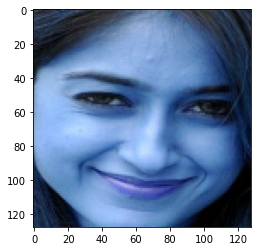

In [48]:
index=101
print('Image: ')
plt.imshow(train_set_x_orig[index])

print(train_set_y[:,index])
print('Associated Output : '+ str(train_set_y[:,index]) )


Let's also plot the cost function and the gradients.

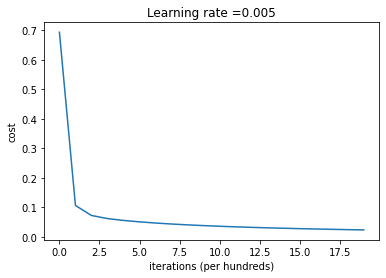

In [49]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

## Further analysis ##

learning rate is: 0.01


C:\Users\Kiran\AppData\Local\Temp/ipykernel_30456/3353849012.py:6: RuntimeWarning: divide by zero encountered in log
  cost = (-1./m)*np.sum((Y*np.log(A)+(1-Y)*np.log(1-A)), axis=1) # compute cost
C:\Users\Kiran\AppData\Local\Temp/ipykernel_30456/3353849012.py:6: RuntimeWarning: invalid value encountered in multiply
  cost = (-1./m)*np.sum((Y*np.log(A)+(1-Y)*np.log(1-A)), axis=1) # compute cost


train accuracy: 99.88888888888889 %
test accuracy: 97.92207792207792 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 97.88888888888889 %
test accuracy: 96.88311688311688 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 95.55555555555556 %
test accuracy: 95.71428571428571 %

-------------------------------------------------------



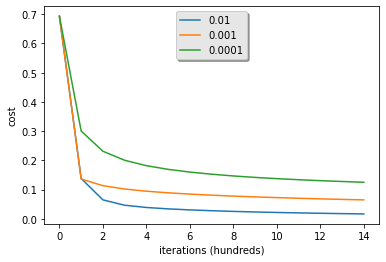

In [50]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

## Test with new image ##

C:\Users\Kiran\AppData\Local\Temp/ipykernel_30456/17470568.py:2: RuntimeWarning: overflow encountered in exp
  s = 1 /(1 + np.exp(-z))


y = 0.0, your algorithm predicts a "Not a Face" picture.


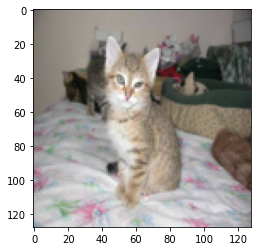

In [51]:
my_image = "cat.jpg" 
fname = my_image
x = np.array(plt.imread(fname))
from PIL import Image
import numpy as np 
img = Image.fromarray(x)
img = img.resize((num_px,num_px))
x = np.asarray(img)
x = x.reshape(1, num_px*num_px*3)
x = x.T
my_predicted_image = predict(d["w"], d["b"], x)
plt.imshow(img)
y = np.squeeze(my_predicted_image)
output = 'Face'
if(y ==0):
    output = 'Not a Face'
print("y = " + str(y) + ", your algorithm predicts a \"" +output +   "\" picture.")

C:\Users\Kiran\AppData\Local\Temp/ipykernel_30456/17470568.py:2: RuntimeWarning: overflow encountered in exp
  s = 1 /(1 + np.exp(-z))


y = 0.0, your algorithm predicts a "Not a Face" picture.


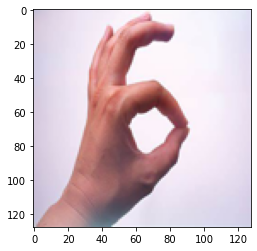

In [54]:
my_image = "my_image.jpg"
fname = my_image

x = np.array(plt.imread(fname))
from PIL import Image
import numpy as np 
img = Image.fromarray(x)
img = img.resize((num_px,num_px))
x = np.asarray(img)
x = x.reshape(1, num_px*num_px*3)
x = x.T

my_predicted_image = predict(d["w"], d["b"], x)

plt.imshow(img)

y = np.squeeze(my_predicted_image)

output = 'Face'
if(y ==0):
    output = 'Not a Face'
    
print("y = " + str(y) + ", your algorithm predicts a \"" +output +   "\" picture.")

y = 1.0, your algorithm predicts a "Face" picture.


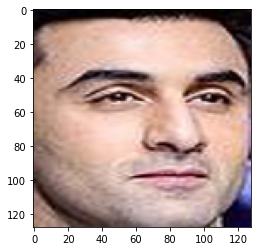

In [55]:
my_image = "face.jpg"
fname = my_image

x = np.array(plt.imread(fname))

from PIL import Image
import numpy as np 

img = Image.fromarray(x)
img = img.resize((num_px,num_px))
x = np.asarray(img)
x = x.reshape(1, num_px*num_px*3)
x = x.T

my_predicted_image = predict(d["w"], d["b"], x)

plt.imshow(img)

y = np.squeeze(my_predicted_image)

output = 'Face'
if(y ==0):
    output = 'Not a Face'
    
print("y = " + str(y) + ", your algorithm predicts a \"" +output +   "\" picture.")